[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreofner/pyGPC/blob/master/demo.ipynb)

In [15]:
import MovingMNIST as MovingMNIST
from model import *

/Users/andre/PycharmProjects/BrainAI/venv/lib/python3.9/site-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Layer 0 cause state torch.Size([64, 64])
Layer 0 hidden state torch.Size([64, 64]) 

Layer 1 cause state torch.Size([64, 64])
Layer 1 hidden state torch.Size([64, 64]) 

Layer 2 cause state torch.Size([64, 32])
Layer 2 hidden state torch.Size([64, 32]) 

Layer 3 cause state torch.Size([64, 32])
Layer 3 hidden state torch.Size([64, 32]) 

SEQ 0 1.0256263415018718
SEQ 1 1.024956464767456
SEQ 2 1.0238484938939412
SEQ 3 1.0231401920318604
SEQ 4 1.0224135716756184
SEQ 5 1.0234683752059937
SEQ 6 1.022922158241272
SEQ 7 1.0236347913742065
SEQ 8 1.0218635002772014
SEQ 9 1.023996909459432
SEQ 10 1.0209750334421794
SEQ 11 1.0228718916575115
SEQ 12 1.0219759146372478
SEQ 13 1.0236714680989583
SEQ 14 1.0220214525858562
SEQ 15 1.0233062505722046
SEQ 16 1.0207241773605347
SEQ 17 1.0241858164469402
SEQ 18 1.021778662999471
SEQ 19 1.0240622758865356
SEQ 20 1.021892786026001
SEQ 21 1.0236797730127971
SEQ 22 1.0214420159657795
SEQ 23 1.024862289428711
SEQ 24 1.020456035931905
SEQ 25 1.023773988087972
SE

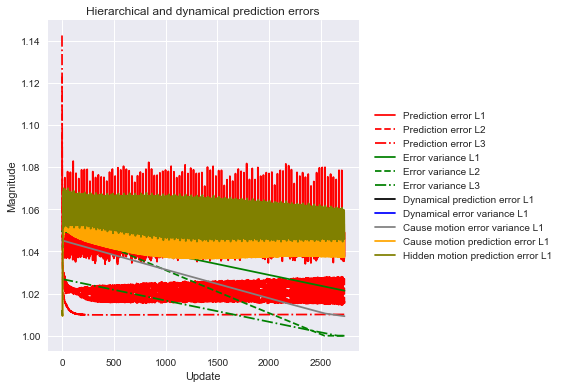

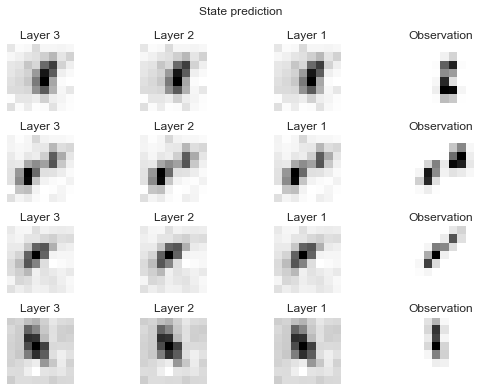

In [23]:
"""
Moving MNIST

- Filtering with 3 hierarchical layers
- Each hierarchical layer can have a dynamical network
"""

VIDEO = True

train_set = MovingMNIST(root='.data/mnist', train=True, download=True,
                        transform=transforms.Compose([transforms.Scale(IMG_SIZE), transforms.ToTensor(), ]))
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)

# hierarchical net with three layers
cause_sizes = [IMG_SIZE * IMG_SIZE, 32, 16, 8]
hidden_sizes = [IMG_SIZE * IMG_SIZE, 32, 16, 8] # todo fix different sizes
net = GPC_net(b_size=BATCH_SIZE, dynamical_net=False,
              cause_sizes=cause_sizes, hidden_sizes=hidden_sizes)
net.print_states()

# the state motion of each hierarchical layer is predicted by a dynamical network
net_d1 = GPC_net(b_size=BATCH_SIZE, dynamical_net=True, obs_layer=net.layers[1],
                cause_sizes=[cause_sizes[1] for l in range(4)], hidden_sizes=[hidden_sizes[1] for l in range(4)])
#net_d2 = GPC_net(b_size=BATCH_SIZE, dynamical_net=True, obs_layer=net.layers[2],
#                cause_sizes=[cause_sizes[2]//(l+1) for l in range(4)],
#                hidden_sizes=[hidden_sizes[2]//(l+1) for l in range(4)])
#net_d3 = GPC_net(b_size=BATCH_SIZE, dynamical_net=True, obs_layer=net.layers[3],
#                cause_sizes=[cause_sizes[3]//(l+1) for l in range(4)],
#                hidden_sizes=[hidden_sizes[3]//(l+1) for l in range(4)])

# logging
errors, cov_h, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3 = [[] for _ in range(8)]
err_g1, err_g2, err_g3, cov_g1, cov_g2, cov_g3 = [[] for _ in range(6)]
err_h1, err_h2, err_h3 = [], [], []

for epoch in range(1):
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=BATCH_SIZE, shuffle=True)
    for seq_id, (seq, _) in enumerate(train_loader):
        vid_in, vid_p1, vid_p2, vid_p3 = [], [], [], []
        seq = torch.transpose(seq, 0,1)
        for id, data in enumerate(seq):
            data = data.reshape([-1,IMG_SIZE*IMG_SIZE]).float()

            for update in range(UPDATES):
                # step hierarchical net
                e, _, _, ch, _ = net.iterative_inference(data, updates=1)

                # step dynamical nets
                eg1, eh1, ed1, cg1, cd1 = net_d1.iterative_inference(updates=1)
                #eg2, eh2, ed2, cg2, cd2 = net_d2.iterative_inference(updates=1)
                #eg3, eh3, ed3, cg3, cd3 = net_d3.iterative_inference(updates=1)

                # logging
                errors, cov_h = errors + e, cov_h + ch
                errors_d1, cov_d1 = errors_d1 + ed1, cov_d1 + cd1
                #rrors_d2, cov_d2 = errors_d2 + ed2, cov_d2 + cd2
                #errors_d3, cov_d3 = errors_d3 + ed3, cov_d3 + cd3
                err_g1, cov_g1 = err_g1 + eg1, cov_g1 + cg1
                #err_g2, cov_g2 = err_g2 + eg2, cov_g2 + cg2
                #err_g3, cov_g3 = err_g3 + eg3, cov_g3 + cg3
                err_h1 = err_h1+eh1;
                #err_h2 = err_h2+eh2;
                # #err_h3 = err_h3+eh3;

            # track state motion
            #[n.state_diff() for n in [net, net_d1, net_d2, net_d3]]
            [n.state_diff() for n in [net, net_d1]]

            # create video
            if VIDEO:
                input, preds = plot_2D(net=net, img_size=IMG_SIZE, plot=False)
                vid_in.append(input.detach().numpy().reshape([IMG_SIZE, IMG_SIZE]))
                vid_p1.append(preds[0][0].reshape([IMG_SIZE, IMG_SIZE]))
                vid_p2.append(preds[1][0].reshape([IMG_SIZE, IMG_SIZE]))
                vid_p3.append(preds[2][0].reshape([IMG_SIZE, IMG_SIZE]))

            if id == 8:
                print(f"SEQ {seq_id}", np.asarray(errors)[-1].mean())
                break
        if seq_id == 100:
            break

# Overview plots
plot_graph(errors, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3,cov_g1,
           cov_g2, cov_g3, err_g1, err_g2, err_g3, err_h1, err_h2, err_h3, cov_h,
           hierarchical=True, g_coords=True, dynamical=True)
input, preds = plot_2D(net=net, img_size=IMG_SIZE, title="State prediction", examples=4, plot=True)

# Create video
if VIDEO:
    for data, name in zip([vid_in, vid_p1], ["input","predl1"]):
        images = np.asarray([v*100 for v in data])
        images *= (255.0 / images.max())
        imgs = [Image.fromarray(img) for img in images]
        imgs[0].save(f"./{name}.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

In [24]:
import IPython
display(IPython.display.Image(open('./input.gif','rb').read()))
display(IPython.display.Image(open('./predl1.gif','rb').read()))

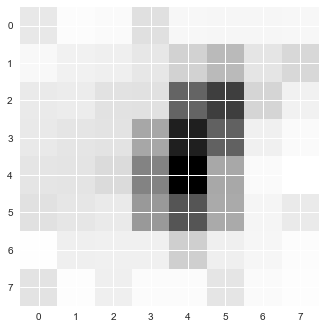

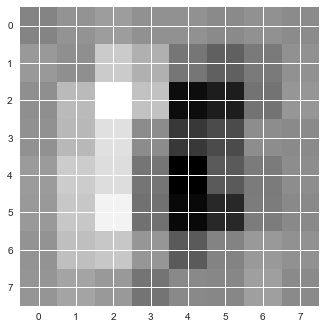

In [32]:
"""
Hierarchical sequence prediction (global trajectory)
"""

len_pred = 10
vid_lt1, vid_lt2, vid_lt3, vid_lt4 = [], [], [], []

for i in range(len_pred):
    # dynamical prediction in first hierarchical layer
    # - without it, we're looking at the currently inferred local tractory
    # - with it, we're looking at the expected (higher orders of) change of the local_trajectory
    # when the prediction error is low, the local trajectory is equal to its expected change
    # -> motion of the mean becomes mean of the motion
    #hidd_trans = net_d1.predict_dynamical(overwrite=True)

    # hierarchical dynamical prediction
    layer_h = 1 # which hierarchical layer to transition # todo make selectable
    pred = net_d1.predict_from(start_layer=2) # dynamical model of layer_h, start_layer: how many gen. coordinates
    net.layers[layer_h].states.cause_state = P(net.layers[layer_h].states.cause_state+torch.tensor(pred[0]))  # cause motion
    net.layers[layer_h].states.hidd_state = P(net.layers[layer_h].states.hidd_state+torch.tensor(pred[1]))  # hidden motion

    # hierarchical prediction from first hierarchical layer
    pred = net.predict_from(start_layer=layer_h+1)

    # plot first and last prediction in sequence
    if i == 0 or i == len_pred-1:
        plt.imshow(pred[0].reshape([IMG_SIZE, IMG_SIZE]))
        plt.show()

    vid_lt1.append(pred[0].reshape([IMG_SIZE,IMG_SIZE]))
    vid_lt2.append(pred[1].reshape([IMG_SIZE,IMG_SIZE]))
    vid_lt3.append(pred[2].reshape([IMG_SIZE,IMG_SIZE]))
    vid_lt4.append(pred[3].reshape([IMG_SIZE,IMG_SIZE]))


In [33]:
# Create video
for data, name in zip([vid_lt1, vid_lt2, vid_lt3, vid_lt4],
                      ["local_traj1_l1", "local_traj2_l1", "local_traj3_l1", "local_traj4_l1"]):
    images = np.asarray([v*100 for v in data])
    images *= (255.0 / images.max())
    imgs = [Image.fromarray(img) for img in images]
    imgs[0].save(f"./{name}.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

In [36]:
# look at the encoded local trajectory
import IPython
for vid in ["local_traj1_l1", "local_traj2_l1", "local_traj3_l1", "local_traj4_l1"]:
    display(IPython.display.Image(open('./'+vid+'.gif','rb').read()))

In [38]:
# Size of lowest dynamical net:
net_d1.net_d

# - Near the sensory input, the dynamical nets are huge, so its more efficient to use them only in deeper layers,
# where they model the dynamics of low-dimensional latent states

Linear(in_features=512, out_features=192, bias=False)